In [1]:
import os
from object_detection.utils.dataset_util import bytes_list_feature
from object_detection.utils.dataset_util import float_list_feature
from object_detection.utils.dataset_util import int64_list_feature
from object_detection.utils.dataset_util import int64_feature
from object_detection.utils.dataset_util import bytes_feature

In [2]:
BASE_PATH="C:/Users/SKS/Desktop/AAIC/Traffic_light/signDatabasePublicFramesOnly"
ANNOT_PATH=os.path.sep.join([BASE_PATH,"allAnnotations.csv"])
TRAIN_RECORD=os.path.sep.join([BASE_PATH,"records/training.record"])
TEST_RECORD=os.path.sep.join([BASE_PATH,"records/testing.record"])
CLASSES_FILE=os.path.sep.join([BASE_PATH,"records/classes.pbtxt"])
TEST_SIZE=0.25
CLASSES={"pedestrianCrossing":1,"signalAhead":2,"stop":3}

In [20]:
class TFAnnotation:
    def __init__(self):
        self.xMins=[]
        self.xMaxs=[]
        self.yMins=[]
        self.yMaxs=[]
        self.textLabels=[]
        self.classes=[]
        self.difficult=[]
        self.image=None
        self.width=None
        self.height=None
        self.encoding=None
        self.filename=None
        
    def build(self):
        w=int64_feature(self.width)
        h=int64_feature(self.height)
        filename=bytes_feature(self.filename.encode('utf8'))
        encoding=bytes_feature(self.filename.encode('utf8'))
        image=bytes_feature(self.image)
        xMins=float_list_feature(self.xMins)
        xMaxs=float_list_feature(self.xMaxs)
        yMins=float_list_feature(self.yMins)
        yMaxs=float_list_feature(self.yMaxs)
        textLabels=bytes_list_feature(self.textLabels)
        classes=int64_list_feature(self.classes)
        difficult=int64_list_feature(self.difficult)
        
        data={
            "image/height":h,
            "image/width":w,
            "image/filename":filename,
            "image/source_id":filename,
            "image/encoded":image,
            "image/format":encoding,
            "image/object/bbox/xmin":xMins,
            "image/object/bbox/xmax":xMaxs,
            "image/object/bbox/ymin":yMins,
            "image/object/bbox/ymax":yMaxs,
            "image/object/class/text":textLabels,
            "image/object/class/label":classes,
            "image/object/difficult":difficult,
            }
        
        return data

In [21]:
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf


In [22]:
CLASSES_FILE

'C:/Users/SKS/Desktop/AAIC/Traffic_light/signDatabasePublicFramesOnly\\records/classes.pbtxt'

In [23]:
f=open(CLASSES_FILE,"w")
for (k,v) in CLASSES.items():
    item = ("item {\n"
    "\tid: " + str(v) + "\n"
    "\tname: '" + k + "'\n"
    "}\n")
    f.write(item)
f.close()

In [24]:
D={}

In [25]:
rows=open(ANNOT_PATH).read().strip().split("\n")

In [27]:
rows[1].split(",")[0].split(";")

['aiua120214-0/frameAnnotations-DataLog02142012_external_camera.avi_annotations/stop_1330545910.avi_image0.png',
 'stop',
 '862',
 '104',
 '916',
 '158',
 '0']

In [8]:
from tqdm import tqdm
for row in tqdm(rows[1:]):
    row=row.split(',')[0].split(';')
    (imagePath,label,startX,startY,endX,endY,_)=row
    (startX,startY)=(float(startX),float(startY))
    (endX,endY)=(float(endX),float(endY))
    if label not in CLASSES:
        continue
    p=os.path.sep.join([BASE_PATH,imagePath])
    b=D.get(p,[])
    b.append((label,(startX,startY,endX,endY)))
    D[p]=b
    
(trainKeys,testKeys)=train_test_split(list(D.keys()),test_size=TEST_SIZE,random_state=42)
datasets=[
    ("train",trainKeys,TRAIN_RECORD),
    ("test",testKeys,TEST_RECORD)
]
for dType,keys,outputPath in datasets:
    print("processing{}".format(dType))
    writer=tf.python_io.TFRecordWriter(outputPath)
    total=0
    for k in keys:
        encoded=tf.gfile.GFile(k,'rb').read()
        encoded=bytes(encoded)
        pilImage=Image.open(k)
        (w,h)=pilImage.size[:2]
        filename=k.split(os.path.sep)[-1]
        encoding=filename[filename.rfind(".")+ 1:]

        tfAnnot=TFAnnotation()
        tfAnnot.image=encoded
        tfAnnot.encoding=encoding
        tfAnnot.filename=filename
        tfAnnot.width=w
        tfAnnot.height=h
        for (label,(startX,startY,endX,endY)) in D[k]:
            xMin=startX/w
            xMax=endX/w
            yMin=startY/h
            yMax=endY/h
            tfAnnot.xMins.append(xMin)
            tfAnnot.xMaxs.append(xMax)
            tfAnnot.yMins.append(yMin)
            tfAnnot.yMaxs.append(yMax)
            tfAnnot.textLabels.append(label.encode('utf8'))
            tfAnnot.classes.append(CLASSES[label])
            tfAnnot.difficult.append(0)

            total+=1
        features=tf.train.Features(feature=tfAnnot.build())
        example=tf.train.Example(features=features)

        writer.write(example.SerializeToString())
    writer.close()
    print('{} saved {}'.format(total,dType))

100%|██████████████████████████████████████████████████████████████████████████| 7855/7855 [00:00<00:00, 262536.72it/s]


processingtrain
2876 saved train
processingtest
955 saved test


In [72]:
#checking our bouding boxes are correctly assigned or not
import cv2
for (label,(startX,startY,endX,endY)) in D[k]:
    xMin=startX/w
    xMax=endX/w
    yMin=startY/h
    yMax=endY/h
    
    image=cv2.imread(k)
    startX=int(xMin*w)
    startY=int(yMin*h)
    endX=int(xMax*w)
    endY=int(yMax*h)
    
    cv2.rectangle(image,(startX,startY),(endX,endY),(0,255,0),2)
    cv2.imshow("image",image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

## Configuration File

In [ ]:
'''
# Faster R-CNN with Resnet-101 (v1) configured for the Oxford-IIIT Pet Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 3
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_resnet101'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.7
    first_stage_max_proposals: 300
    first_stage_localization_loss_weight: 2.0
    first_stage_objectness_loss_weight: 1.0
    initial_crop_size: 14
    maxpool_kernel_size: 2
    maxpool_stride: 2
    second_stage_box_predictor {
      mask_rcnn_box_predictor {
        use_dropout: false
        dropout_keep_probability: 1.0
        fc_hyperparams {
          op: FC
          regularizer {
            l2_regularizer {
              weight: 0.0
            }
          }
          initializer {
            variance_scaling_initializer {
              factor: 1.0
              uniform: true
              mode: FAN_AVG
            }
          }
        }
      }
    }
    second_stage_post_processing {
      batch_non_max_suppression {
        score_threshold: 0.0
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 300
      }
      score_converter: SOFTMAX
    }
    second_stage_localization_loss_weight: 2.0
    second_stage_classification_loss_weight: 1.0
  }
}

train_config: {
  batch_size: 1
  optimizer {
    momentum_optimizer: {
      learning_rate: {
        manual_step_learning_rate {
          initial_learning_rate: 0.0003
          schedule {
            step: 900000
            learning_rate: .00003
          }
          schedule {
            step: 1200000
            learning_rate: .000003
          }
        }
      }
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  gradient_clipping_by_norm: 10.0
  fine_tune_checkpoint: "C:/Users/SKS/Desktop/AAIC/Traffic_light/experiments/training/faster_rcnn_resnet101_coco_2018_01_28/model.ckpt"
  from_detection_checkpoint: true
  load_all_detection_checkpoint_vars: true
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 50000
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
}

train_input_reader: {
  tf_record_input_reader {
    input_path: "C:/Users/SKS/Desktop/AAIC/Traffic_light/signDatabasePublicFramesOnly/records/training.record"
  }
  label_map_path: "C:/Users/SKS/Desktop/AAIC/Traffic_light/signDatabasePublicFramesOnly/records/classes.pbtxt"
}

eval_config: {
  metrics_set: "coco_detection_metrics"
  num_examples: 955
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "C:/Users/SKS/Desktop/AAIC/Traffic_light/signDatabasePublicFramesOnly/records/testing.record"
  }
  label_map_path: "C:/Users/SKS/Desktop/AAIC/Traffic_light/signDatabasePublicFramesOnly/records/classes.pbtxt"
  shuffle: false
  num_readers: 1
}

'''

## Command for Training for Faster-RCNN

####  python object_detection/legacy/train.py --logtostderr --pipeline_config_path C:/Users/SKS/Desktop/AAIC/Traffic_light/experiments/training/faster_rcnn_lisa.config --train_dir C:/Users/SKS/Desktop/AAIC/Traffic_light/experiments/training

## Command for Evaluation for Faster-RCNN

####  python object_detection/legacy/eval.py --logtostderr --pipeline_config_path C:/Users/SKS/Desktop/AAIC/Traffic_light/experiments/training/faster_rcnn_lisa.config --checkpoint_dir C:/Users/SKS/Desktop/AAIC/Traffic_light/experiments/training --eval_dir C:/Users/SKS/Desktop/AAIC/Traffic_light/experiments/evaluation

## Command for Exporting the model 

#### python .\export_inference_graph.py --input_type image_tensor --pipeline_config_path C:/Users/SKS/Desktop/AAIC/Traffic_light/experiments/training/faster_rcnn_lisa.config --trained_checkpoint_prefix C:/Users/SKS/Desktop/AAIC/Traffic_light/experiments/training/model.ckpt-13028 --output_directory C:/Users/SKS/Desktop/AAIC/Traffic_light/experiments/exported_model

# Loss Graph

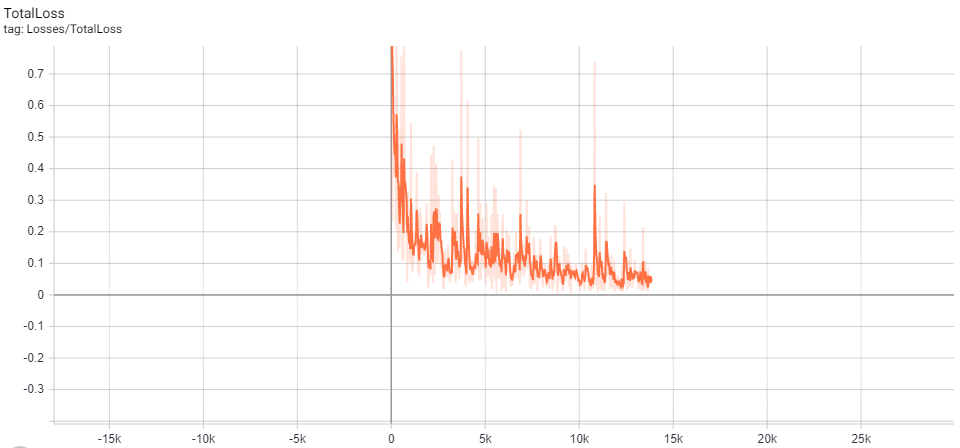

In [9]:
from IPython.display import Image
Image(filename='loss.png')

In [3]:
from object_detection.utils import label_map_util
import tensorflow as tf
import numpy as np
import imutils
import cv2

In [4]:
model="C:/Users/SKS/Desktop/AAIC/Traffic_light/experiments/exported_model/frozen_inference_graph.pb"
labels="C:/Users/SKS/Desktop/AAIC/Traffic_light/signDatabasePublicFramesOnly/records/classes.pbtxt"
image="C:/Users/SKS/Desktop/AAIC/Traffic_light/image_peda.jpg"
min_confidence=0.5
num_classes=3

In [5]:
colors=np.random.uniform(0,255,size=(3,3))
model=tf.Graph()
with model.as_default():
    graphDef=tf.GraphDef()
    with tf.gfile.GFile("C:/Users/SKS/Desktop/AAIC/Traffic_light/experiments/exported_model/frozen_inference_graph.pb","rb") as f:
        serializedGraph=f.read()
        graphDef.ParseFromString(serializedGraph)
        tf.import_graph_def(graphDef,name="")
        
labelMap=label_map_util.load_labelmap(labels)
categories=label_map_util.convert_label_map_to_categories(labelMap,max_num_classes=num_classes,use_display_name=True)
categoryIdx=label_map_util.create_category_index(categories)

In [11]:
categoryIdx

{1: {'id': 1, 'name': 'pedestrianCrossing'},
 2: {'id': 2, 'name': 'signalAhead'},
 3: {'id': 3, 'name': 'stop'}}

In [12]:
categories

[{'id': 1, 'name': 'pedestrianCrossing'},
 {'id': 2, 'name': 'signalAhead'},
 {'id': 3, 'name': 'stop'}]

In [7]:
from matplotlib import pyplot
with model.as_default():
    with tf.Session(graph=model) as sess:
        imageTensor=model.get_tensor_by_name("image_tensor:0")
        boxesTensor=model.get_tensor_by_name("detection_boxes:0")
        scoresTensor=model.get_tensor_by_name("detection_scores:0")
        classesTensor=model.get_tensor_by_name("detection_classes:0")
        numDetections=model.get_tensor_by_name("num_detections:0")
        
        image=cv2.imread("C:/Users/SKS/Desktop/AAIC/Traffic_light/image_peda.jpg")
        (H,W)= image.shape[:2]
        
        if W>H and W>1000:
            image=imutils.resize(image,width=1000)
        elif H>W and H>1000:
            image=imutils.resize(image,height=1000)
            
        (H,W)=image.shape[:2]
        output=image.copy()
        image=cv2.cvtColor(image.copy(),cv2.COLOR_BGR2RGB)
        image=np.expand_dims(image,axis=0)
        
        (boxes,scores,labels,N)= sess.run([boxesTensor,scoresTensor,classesTensor,numDetections],feed_dict={imageTensor:image})
        boxes=np.squeeze(boxes)
        scores=np.squeeze(scores)
        labels=np.squeeze(labels)
        o=[]
        
        for (box,score,label) in zip(boxes,scores,labels):
            if score<0.5:
                continue
            (startY,startX,endY,endX)=box
            startX=int(startX*W)
            startY=int(startY*H)
            endX=int(endX*W)
            endY=int(endY*H)
         
            label=categoryIdx[label]
            idx=int(label["id"])-1
            o.append(label["name"])
            label="{}: {:.2f}".format(label["name"],score)
            cv2.rectangle(output,(startX,startY),(endX,endY),colors[idx],2)
            y=startY-10 if startY-10>10 else startY+10 
            cv2.putText(output,label,(startX,y),cv2.FONT_HERSHEY_SIMPLEX,0.3,colors[idx],1)
        cv2.imshow("output",output)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        

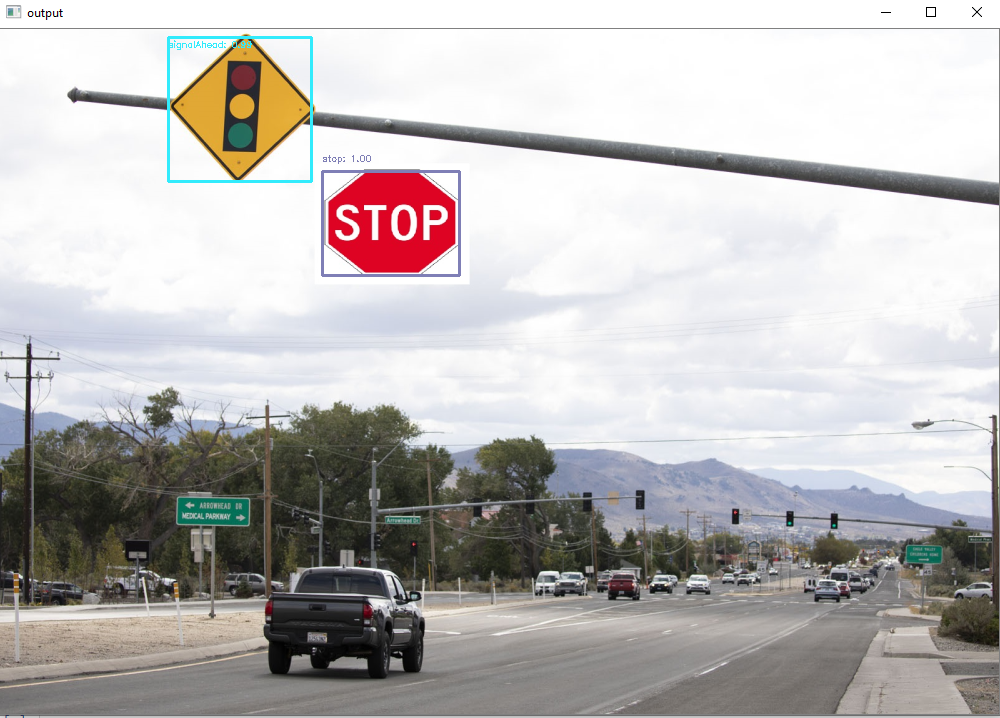

In [8]:
from IPython.display import Image
Image(filename='detection.png')